In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.lines as mlines
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# functions for loading the datasets
def load_stock():
    df_stock = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                       usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                       dtype={'Local_Date_Time': str,
                              'RIC': str, 
                              'Open': np.float64,
                              'High': np.float64,
                              'Low': np.float64,
                              'Close': np.float64,
                              'VWAP': np.float64,
                              'NumberOfTrades': int,
                              'Volume': int},
                       skipinitialspace=True,
                       parse_dates=True)
    return df_stock

def load_stockqqq():
    df_stockqqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
    return df_stockqqq

def load_auction():
    df_auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                          skipinitialspace=True,
                          parse_dates=True)
    return df_auction

def load_auctionqqq():
    df_auctionqqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
    return df_auctionqqq

In [3]:
# Trade data
def load_stockdata(df_stock, df_stockqqq, stock_name):
    #NSQ_OneYear100closeA_Sept21.csv
    df_stockRIC = df_stock[df_stock['RIC'] == stock_name]
    df_stockRIC['Date'] = pd.to_datetime(df_stockRIC['Local_Date_Time']).dt.date
    df_stockqqq['Date'] = pd.to_datetime(df_stockqqq['Local_Date_Time']).dt.date
    
    return df_stockRIC, df_stockqqq

In [4]:
# Auction price data
def load_auctiondata(df_auction, df_auctionqqq, stock_name):
    df_auctionRIC = df_auction[df_auction['RIC'] == stock_name]
    df_auctionRIC['Date'] = pd.to_datetime(df_auctionRIC['Local_Date_Time']).dt.date
    df_auctionqqq['Date'] = pd.to_datetime(df_auctionqqq['Local_Date_Time']).dt.date
    
    return df_auctionRIC, df_auctionqqq

### Data processing

In [5]:
# Data Processing (10 minute intervals)

def get_voldf(df_stockRIC, df_auctionRIC):
    dates = df_stockRIC['Date'].unique()
    dates_final = []
    stocks = []
    daily_return = []
    auction_log_returns = []
    auction_log_returns_340350 = []
    daily_volatility = []
    daily_volatility_minus4pm = []
    avg_20day_volatility = []

    for date in dates:

        stock_today = df_stockRIC[df_stockRIC['Date'] == date]
        df_auctionRIC_today = df_auctionRIC[df_auctionRIC['Date'] == date]
        stock_today = stock_today.set_index(pd.DatetimeIndex(stock_today['Local_Date_Time']))
        stock_today_10min_max = pd.DataFrame(stock_today['High'].resample("10T").max())
        stock_today_10min_min = pd.DataFrame(stock_today['Low'].resample("10T").min())
        stock_today_10min_open = pd.DataFrame(stock_today['Open'].resample("10T").first())
        stock_today_10min_close = pd.DataFrame(stock_today['Close'].resample("10T").last())
        stock_today_10min = stock_today_10min_max.join(stock_today_10min_min)
        stock_today_10min = stock_today_10min.join(stock_today_10min_open)
        stock_today_10min = stock_today_10min.join(stock_today_10min_close)

        # Garman and Klass Volatility formula
        stock_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(stock_today_10min['High']/stock_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(stock_today_10min['Close']/stock_today_10min['Open'])))
        #stock_today_10min['log_returns'] = abs(np.log(stock_today_10min['Close']/stock_today_10min['Open'])) # alternate volatility formula

        vol_today = [val for val in stock_today_10min['Volatility'].values]
        return_today = (stock_today_10min['Close']/stock_today_10min['Open']).values

        if len(vol_today) != 39: # Skip if there are fewer than 390 minutes of trading data
            continue

        # Dates for which the trade data is complete
        dates_final.append(date)

        # Change the 39th 10min interval to include the auction price (instead of close)
        auction_volatility = np.sqrt(0.5*np.square(np.log(stock_today_10min['High'][-1]/stock_today_10min['Low'][-1])) - (2*np.log(2)-1)*np.square(np.log(df_auctionRIC_today['Price'].iloc[0]/stock_today_10min['Open'][-1])))
        vol_today[-1] = auction_volatility

        # 10 minute interval volatility * number of complete trade days
        stocks.append(vol_today)

        # Daily raw return
        daily_return.append(return_today)

        # Auction Volatility Information
        auction_log_returns_today = abs(np.log(df_auctionRIC_today['Price'].iloc[0]/stock_today_10min['Open'][-1]))
        auction_log_returns.append(auction_log_returns_today)

        # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
        auction_log_returns_today_340350 = abs(np.log(stock_today_10min['Open'][-1]/stock_today_10min['Open'][-2]))
        auction_log_returns_340350.append(auction_log_returns_today_340350)

        # Average daily volatility (later used for EWMA 20Day)
        daily_volatility.append(sum(vol_today))
        daily_volatility_minus4pm.append(sum(vol_today[:-1]))

    daily_return = np.array(daily_return)
    vol_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
    vol_df['volatility_ewma20'] = np.array([None] + [i for i in vol_df['daily_volatility'].ewm(span=20).mean()][:-1])

    stocks = stocks[20:]
    stocks = np.vstack(stocks).T # Training data for Anderson model
    avg_20day_volatility_raw = np.array(vol_df['volatility_ewma20'])
    avg_20day_volatility = np.array(vol_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model
    
    return vol_df

### Model 1C

In [51]:
def mod1C_results(vol_df):

    vol_df['auction'] = vol_df['daily_volatility'] - vol_df['daily_volatility_minus4pm']
    vol_df['volatility_ewma20_minus4pm'] = np.array([None] + [i for i in vol_df['daily_volatility_minus4pm'].ewm(span=20).mean()][:-1])
    vol_df['volatility_ewma20_auction'] = np.array([None] + [i for i in vol_df['auction'].ewm(span=20).mean()][:-1])
    vol_df

    vol_df['volatility_ewma20_minus4pm_yest'] = vol_df['volatility_ewma20_minus4pm'].shift(1)
    vol_df['volatility_ewma20_auction_1c'] = vol_df['daily_volatility_minus4pm']/vol_df['volatility_ewma20_minus4pm_yest']*vol_df['volatility_ewma20_auction']

    df_mod1C = pd.DataFrame()
    df_mod1C['Date'] = vol_df['Date'][20:]
    df_mod1C['Actual_Volatility'] = vol_df['auction'][20:]
    df_mod1C['Predicted_Volatility'] = vol_df['volatility_ewma20_auction_1c'][20:]

    R2 = r2_score(df_mod1C['Actual_Volatility'][-211:], df_mod1C['Predicted_Volatility'][-211:])
    
    return df_mod1C, R2

In [48]:
def get_df_mod1C(df_stock, df_stockqqq, df_auction, df_auctionqqq, stock_name):
    
    df_stockRIC, df_stockqqq = load_stockdata(df_stock, df_stockqqq, stock_name)
    df_auctionRIC, df_auctionqqq = load_auctiondata(df_auction, df_auctionqqq, stock_name)
    vol_df = get_voldf(df_stockRIC, df_auctionRIC)

    df_mod1C, R2 = mod1C_results(vol_df)
    
    return df_mod1C, R2

# Results

In [15]:
# load the datasets
df_stock = load_stock()
df_stockqqq = load_stockqqq()
df_auction = load_auction()
df_auctionqqq = load_auctionqqq()

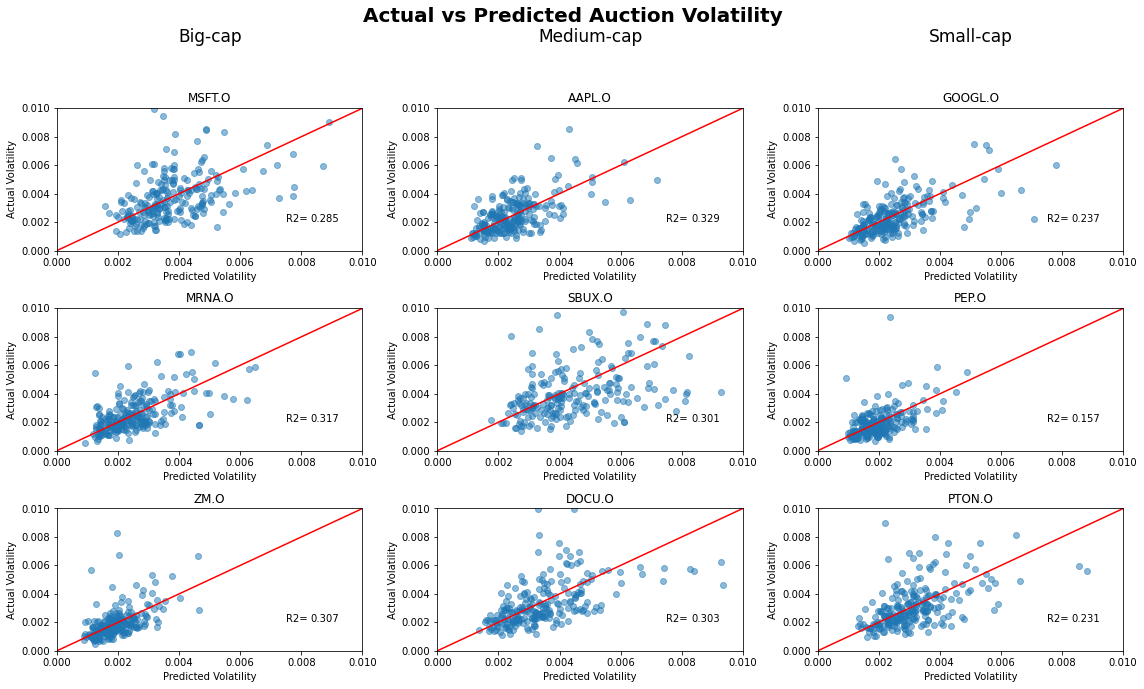

In [209]:
# choose interested stocks
stock_list = ["MSFT.O", "AAPL.O", "GOOGL.O", "MRNA.O", "SBUX.O", "PEP.O",
              "ZM.O", "DOCU.O", "PTON.O"]

# draw the scatterplots
col_names = ['Big-cap', 'Medium-cap', 'Small-cap']

count = 0
fig, axes = plt.subplots(nrows=3+1, ncols=3, figsize= (16,14), gridspec_kw={"height_ratios":[0.02, 1, 1, 1]})
xy_line = (0,1)

for i, ax in enumerate(zip(axes.flatten()[3:], stock_list)):
    
    df_mod1C, R2 = get_df_mod1C(df_stock, df_stockqqq, df_auction, df_auctionqqq, stock_name)
    
    stock_name = ax[1]
    ax = ax[0]
    
    ax.scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
    ax.plot(xy_line, 'r', label='Random guess')
    ax.set_xbound(0, 0.010)
    ax.set_ybound(0, 0.010)
    ax.set_title(stock_name)
    ax.text(0.0075, 0.002, 'R2=')
    ax.text(0.0083, 0.002, round(R2,3))
    ax.set_xlabel("Predicted Volatility")
    ax.set_ylabel("Actual Volatility")
    
for i, ax in enumerate(zip(axes.flatten()[:3], col_names)):
    col = ax[1]
    ax = ax[0]
    
    ax.axis("off")
    ax.set_title(col, fontsize=17, fontweight='normal')

fig.suptitle("Actual vs Predicted Auction Volatility", fontsize=20, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 1])

plt.show()

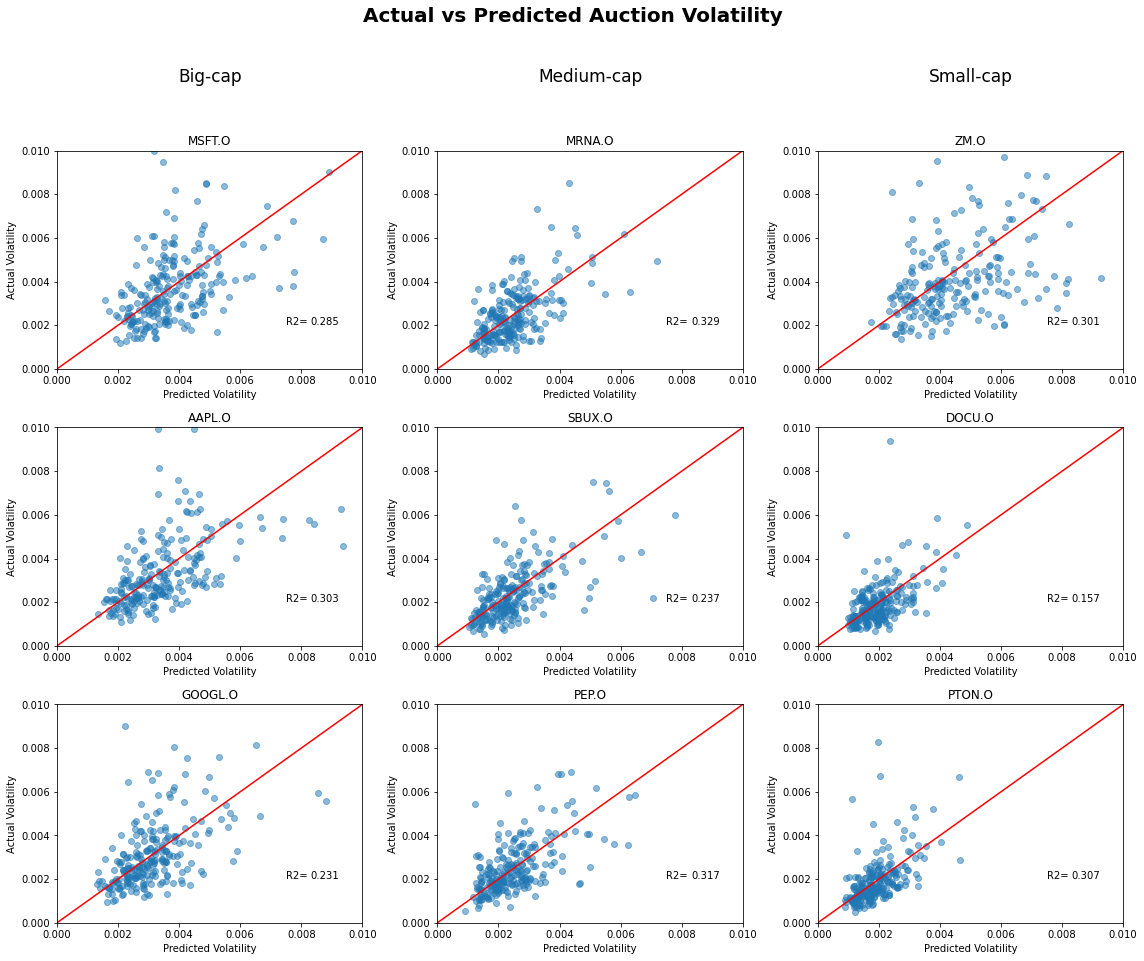

In [220]:
# choose interested stocks
stock_list = ["MSFT.O", "MRNA.O", "ZM.O",
              "AAPL.O", "SBUX.O", "DOCU.O",
              "GOOGL.O", "PEP.O", "PTON.O"]

# draw the scatterplots
col_names = ['Big-cap', 'Medium-cap', 'Small-cap']

count = 0
fig, axes = plt.subplots(nrows=3+1, ncols=3, figsize= (16,14), gridspec_kw={"height_ratios":[0.02, 1, 1, 1]})
xy_line = (0,1)

for i, ax in enumerate(zip(axes.flatten()[3:], stock_list)):
    
    df_mod1C, R2 = get_df_mod1C(df_stock, df_stockqqq, df_auction, df_auctionqqq, stock_name)
    
    stock_name = ax[1]
    ax = ax[0]
    
    ax.scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
    ax.plot(xy_line, 'r', label='Random guess')
    ax.set_xbound(0, 0.010)
    ax.set_ybound(0, 0.010)
    ax.set_title(stock_name)
    ax.text(0.0075, 0.002, 'R2=')
    ax.text(0.0083, 0.002, round(R2,3))
    ax.set_xlabel("Predicted Volatility")
    ax.set_ylabel("Actual Volatility")
    
for i, ax in enumerate(zip(axes.flatten()[:3], col_names)):
    col = ax[1]
    ax = ax[0]
    
    ax.axis("off")
    ax.set_title(col, fontsize=17, fontweight='normal')

fig.suptitle("Actual vs Predicted Auction Volatility", fontsize=20, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.9)

plt.show()

Text(0.5, 0.98, 'Actual vs Predicted Auction Volatility')

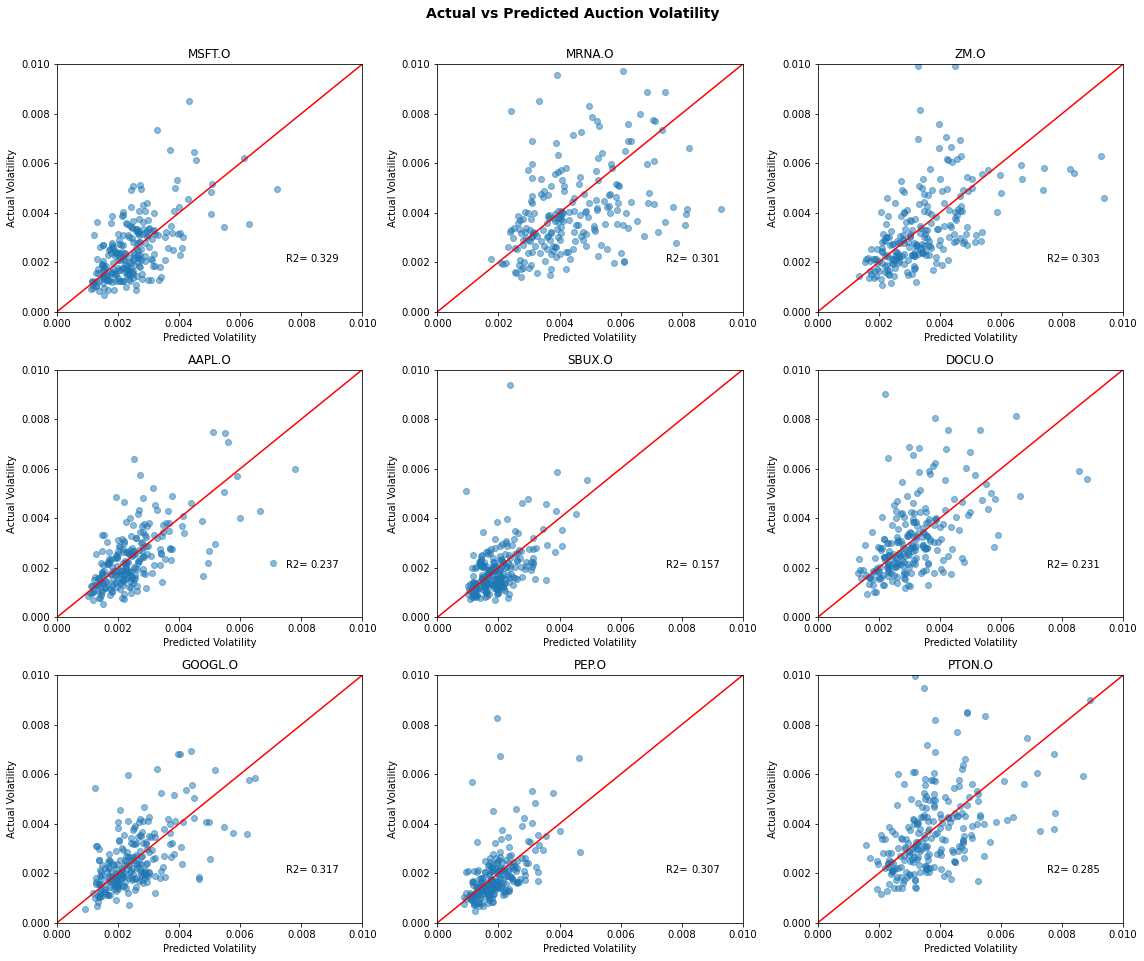

In [221]:
# choose interested stocks
stock_list = ["MSFT.O", "AAPL.O", "GOOGL.O", "MRNA.O", "SBUX.O", "PEP.O",
              "ZM.O", "DOCU.O", "PTON.O"]

# draw the scatterplots
count = 0 
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,14))
xy_line = (0,1)
for i, stock_name in enumerate(stock_list):
    df_mod1C, R2 = get_df_mod1C(df_stock, df_stockqqq, df_auction, df_auctionqqq, stock_name)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if count < 3:
        ax[i,0].scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
        ax[i,0].plot(xy_line, 'r', label='Random guess')
        ax[i,0].set_xbound(0, 0.010)
        ax[i,0].set_ybound(0, 0.010)
        ax[i,0].set_title(stock_name)
        ax[i,0].text(0.0075, 0.002, 'R2=')
        ax[i,0].text(0.0083, 0.002, round(R2,3))
        ax[i,0].set_xlabel("Predicted Volatility")
        ax[i,0].set_ylabel("Actual Volatility")
        
    elif count < 6:
        i -= 3
        ax[i,1].scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
        ax[i,1].plot(xy_line, 'r', label='Random guess')
        ax[i,1].set_xbound(0, 0.010)
        ax[i,1].set_ybound(0, 0.010)
        ax[i,1].set_title(stock_name)
        ax[i,1].text(0.0075, 0.002, 'R2=')
        ax[i,1].text(0.0083, 0.002, round(R2,3))
        ax[i,1].set_xlabel("Predicted Volatility")
        ax[i,1].set_ylabel("Actual Volatility")
        
    else:
        i -= 6
        ax[i,2].scatter(df_mod1C['Predicted_Volatility'], df_mod1C['Actual_Volatility'], alpha=0.5)
        ax[i,2].plot(xy_line, 'r', label='Random guess')
        ax[i,2].set_xbound(0, 0.010)
        ax[i,2].set_ybound(0, 0.010)
        ax[i,2].set_title(stock_name)
        ax[i,2].text(0.0075, 0.002, 'R2=')
        ax[i,2].text(0.0083, 0.002, round(R2,3))
        ax[i,2].set_xlabel("Predicted Volatility")
        ax[i,2].set_ylabel("Actual Volatility")
       
    count += 1

fig.suptitle("Actual vs Predicted Auction Volatility", fontsize=14, fontweight='bold')